In [1]:
import wandb
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
from sklearn.datasets import fetch_openml
from joblib import Parallel, delayed

In [2]:
wandb.login()

wandb: Currently logged in as: brinashong. Use `wandb login --relogin` to force relogin


True

In [3]:
%run 'common.ipynb'

In [4]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TEST_COUNT = 500

In [5]:
%run cicids.ipynb

In [6]:
# Should already be one hot encoded and label encoded
# all_df, main_labels, config = get_processed_covtype_df()
# all_df, main_labels, config = get_processed_cicids_df()
all_df, main_labels, config = get_processed_cicids_df()
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

Normal class:  0    Benign
dtype: object
TARGET_DICT {0: 'Benign', 1: 'Botnet', 2: 'Bruteforce', 3: 'DDoS', 4: 'DoS', 5: 'Infiltration', 6: 'Portscan', 7: 'Webattack'}
NORMAL_TARGET 0
main_labels Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Fwd Packets Length Total', 'Bwd Packets Length Total',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'SYN Flag 

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ClassLabel
0,51990738,3,1,43.0,6.0,31.0,14.333333,14.433757,6.0,6.00000,...,20,0.0,0.0,0.0,0.0,51940550.0,0.00,51940552.0,51940552.0,0
1,117384013,80,144,974.0,199741.0,275.0,12.175000,44.683636,1460.0,1387.09030,...,20,506187.0,628091.8,950315.0,62059.0,58155176.0,132745.16,58249039.0,58061309.0,0
2,246,2,2,64.0,204.0,32.0,32.000000,0.000000,102.0,102.00000,...,32,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
3,200929,13,11,1293.0,4610.0,694.0,99.461540,189.770750,1430.0,419.09090,...,20,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
4,2446230,8,7,1144.0,1581.0,677.0,143.000000,227.969920,1173.0,225.85715,...,20,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0


In [7]:
all_df.shape

(2037240, 58)

In [8]:
# Create a folder to save the CSVs
remove_files_from_directory(OUTPUT_FOLDER)
remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [9]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [10]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(1629792, 57) (407448, 57) (1629792,) (407448,)


In [11]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ClassLabel
1285014,3850770,14,8,1440.0,1731.0,725.0,102.857140,191.172840,1179.0,216.375,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1142876,4664549,5,4,935.0,790.0,935.0,187.000000,418.144700,395.0,197.500,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1229394,1301287,6,5,455.0,338.0,140.0,75.833336,62.936210,145.0,67.600,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
957100,60002992,2,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0,0.0,0.0,0.0,0.0,60000000.0,0.0,60000000.0,60000000.0,0
1567448,5048320,3,1,12.0,2.0,6.0,4.000000,3.464102,2.0,2.000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [12]:
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the numeric columns
X_train_scaled_df = X_train_df.copy()
X_train_scaled_df[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train_scaled_df[NUMERICAL_COLUMNS])
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
X_test_scaled_df = X_test_df.copy()
X_test_scaled_df[NUMERICAL_COLUMNS] = scaler.transform(X_test_scaled_df[NUMERICAL_COLUMNS])
# print('X_test_scaled_df', X_test_scaled_df)

In [13]:
# Loop through each cover type and create a dataset
benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)

benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    a, b = 0, 0  # Track abnormal and benign sample counts
    
    # Open the output file for writing
    output_path = os.path.join(OUTPUT_FOLDER, f"{name}.csv")
    with open(output_path, "w") as ths:
        ths.write(','.join(main_labels) + "\n")
        
        # Calculate the number of benign samples based on the fixed ratio
        abnormal_count = abnormal_type_dict[label]
        benign_num = max(min(int(abnormal_count * benign_ratio), benign), min_benign_samples)
        # print(f'Creating {name}.csv with {benign_num} benign samples and {abnormal_count} abnormal samples.')

        # Collect normal (benign) rows and abnormal rows
        benign_rows = []
        abnormal_rows = []

        # Read all_data.csv line by line and collect rows
        with open("all_data.csv", "r") as file:
            for i, line in enumerate(file):
                if i == 0:
                    continue  # Skip the header row
                k = line.strip().split(",")  # Strip newline and split the line
                
                # Collect normal rows
                if int(k[-1]) == NORMAL_TARGET:
                    benign_rows.append(line)
                
                # Collect abnormal rows that match the current label
                elif int(k[-1]) == label:
                    abnormal_rows.append(line)

        # Randomly sample benign rows
        if len(benign_rows) > benign_num:
            benign_rows = random.sample(benign_rows, benign_num)
        else:
            benign_rows = random.sample(benign_rows, len(benign_rows))  # Shuffle if fewer than required

        # Concatenate benign and abnormal rows
        combined_rows = benign_rows + abnormal_rows
        
        # Shuffle the combined rows
        random.shuffle(combined_rows)

        # Write the shuffled rows to the output file
        for row in combined_rows:
            ths.write(row)

        # Print number of rows written
        b = len(benign_rows)
        a = len(abnormal_rows)
        print(f"{name}.csv created with {a + b} rows. ({b} benign and {a} abnormal rows)")

print("All datasets created successfully!")

abnormal_type_dict {0: 1597040, 3: 274283, 4: 87943, 1: 32390, 2: 23289, 5: 21107, 7: 686, 6: 502}
Botnet.csv created with 97170 rows. (64780 benign and 32390 abnormal rows)
Bruteforce.csv created with 69867 rows. (46578 benign and 23289 abnormal rows)
DDoS.csv created with 822849 rows. (548566 benign and 274283 abnormal rows)
DoS.csv created with 263829 rows. (175886 benign and 87943 abnormal rows)
Infiltration.csv created with 63321 rows. (42214 benign and 21107 abnormal rows)
Portscan.csv created with 1506 rows. (1004 benign and 502 abnormal rows)
Webattack.csv created with 2058 rows. (1372 benign and 686 abnormal rows)
All datasets created successfully!


In [25]:
# tdf = pd.read_csv('csv_files/imap.csv')
# tdf['attack'].unique()

array([16,  6])

In [35]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)# It creates a list of file names in the "attacks" folder.
print('csv_files',csv_files)

ths = open("importance_list.csv", "w")
feature_importances = {}
ensemble_models = {}
SVMs = {}

def train_individual_model(model, X, y):
    model.fit(X, y)
    return model
    
def train_models(csv_file):
    print('csv file', csv_file)
    
    X_df, y_df, df = get_anomaly_X_y_from_csv(csv_file, main_labels, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER)

    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X_df, y_df)
    importances = forest.feature_importances_
    label = csv_file.split(".")[0]
    print('importances', importances, label)
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False)
    important_features = impor_bars['Features'].to_list()[:5]
    impor_bars = impor_bars.set_index('Features')
    print('important_features', important_features)
    feature_importances[label] = important_features

    X_scaled_df = X_df.copy()
    X_scaled_df[NUMERICAL_COLUMNS] = scaler.transform(X_scaled_df[NUMERICAL_COLUMNS])

    svm = SVC()
    knn = KNeighborsClassifier(n_neighbors=5)
    decision_tree = DecisionTreeClassifier()
    random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
    logistic_regression = LogisticRegression(max_iter=1000)
    gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)
    
    X_train_class = df.iloc[:, df.columns.get_indexer(important_features)]
    X_train_class_scaled = X_scaled_df.iloc[:, df.columns.get_indexer(important_features)]
    # print('X_train_class', X_train_class)
    y_train_class = y_df
    # print('y_train_class', y_train_class)
    if len(y_train_class) > 0:  # Ensure there are samples for this class
        scaled_models = [svm, knn, logistic_regression]
        non_scaled_models = [decision_tree, random_forest, gradient_boosting]
        
        # Train scaled models
        scaled_models = Parallel(n_jobs=-1)(
            delayed(train_individual_model)(model, X_train_class_scaled, y_train_class)
            for model in scaled_models
        )
        
        # Train non-scaled models
        non_scaled_models = Parallel(n_jobs=-1)(
            delayed(train_individual_model)(model, X_train_class, y_train_class)
            for model in non_scaled_models
        )
        
        # Combine trained models
        svm, knn, logistic_regression = scaled_models
        decision_tree, random_forest, gradient_boosting = non_scaled_models
    else:
        print(f'no data for {label}')
        
    SVMs[label] = svm

    # Create an ensemble from the classifiers using VotingClassifier
    voting_clf = VotingClassifier(estimators=[
        ('svm', svm),
        ('knn', knn),
        ('dt', decision_tree),
        ('rf', random_forest),
        ('lr', logistic_regression),
        ('gb', gradient_boosting)
    ], voting='hard')  # Use 'soft' for probability-based voting
    voting_clf.fit(X_train_class_scaled, y_train_class)
    ensemble_models[label] = voting_clf
    
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    # #printing the feature importances  
    count=0
    fea_ture=label+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(label,"importance list:")
    print(label,"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(label+" Cover type - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig(os.path.join(FEATURE_FOLDER, label+".pdf"),bbox_inches='tight', format = 'pdf')
    # ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

    return feature_importances, ensemble_models, SVMs

# Parallelize the training across multiple CSV files
results = Parallel(n_jobs=-1)(delayed(train_models)(csv_file) for csv_file in csv_files)

# After parallel execution, collect results
for feature_importances_res, ensemble_models_res, SVMs_res in results:
    feature_importances.update(feature_importances_res)
    ensemble_models.update(ensemble_models_res)
    SVMs.update(SVMs_res)

# Write feature importances to a CSV file after parallel processing
# with open("importance_list.csv", "w") as ths:
#     for label, features in feature_importances.items():
#         fea_ture = f"{label}=[{','.join(f'\"{feat}\"' for feat in features)}]\n"
#         ths.write(fea_ture)
  
print('feature_importances', feature_importances)
print("Total operation time: = ", time.time() - seconds, "seconds")
ths.close()

csv_files ['named.csv', 'snmpgetattack.csv', 'ipsweep.csv', 'httptunnel.csv', 'sendmail.csv', 'guess_passwd.csv', 'satan.csv', 'ps.csv', 'ftp_write.csv', 'xlock.csv', 'udpstorm.csv', 'teardrop.csv', 'phf.csv', 'pod.csv', 'perl.csv', 'nmap.csv', 'portsweep.csv', 'saint.csv', 'rootkit.csv', 'warezmaster.csv', 'xsnoop.csv', 'sqlattack.csv', 'processtable.csv', 'snmpguess.csv', 'mailbomb.csv', 'imap.csv', 'neptune.csv', 'xterm.csv', 'mscan.csv', 'buffer_overflow.csv', 'loadmodule.csv', 'worm.csv', 'multihop.csv', 'back.csv', 'apache2.csv', 'land.csv', 'smurf.csv']


ValueError: Number of passed names did not match number of header fields in the file

csv file DDoS.csv
importances [1.60698851e-02 4.79481521e-05 5.71004082e-03 5.90252513e-02
 8.71731407e-05 2.04755825e-01 1.11785288e-01 1.31500660e-04
 2.45746502e-04 1.18198471e-04 6.50812013e-05 6.43753046e-04
 1.35109669e-04 2.08407395e-04 4.70886195e-03 1.36397523e-04
 4.07250036e-03 9.65113515e-05 3.69896562e-04 2.48205954e-05
 1.03908005e-04 1.52271584e-02 5.52579714e-05 1.31408220e-03
 6.41884922e-05 4.19923882e-05 2.55520331e-05 7.60812125e-06
 1.01320109e-01 6.58367610e-03 3.38467455e-04 6.49892279e-03
 3.86385815e-04 1.01484106e-04 1.35092117e-04 1.38364412e-04
 8.10977626e-04 1.47898099e-04 1.88709227e-04 1.06524995e-01
 1.28723438e-04 4.60338799e-05 5.72306375e-02 6.14614877e-03
 8.92818727e-05 2.78840556e-01 9.45605637e-04 2.19906310e-03
 4.15698607e-04 4.44864411e-04 3.27934697e-06 4.42476884e-04
 4.31768827e-04 5.18867731e-06 2.07434856e-06 6.51978534e-06
 4.16905176e-03] DDoS
important_features ['Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packets Length Tot

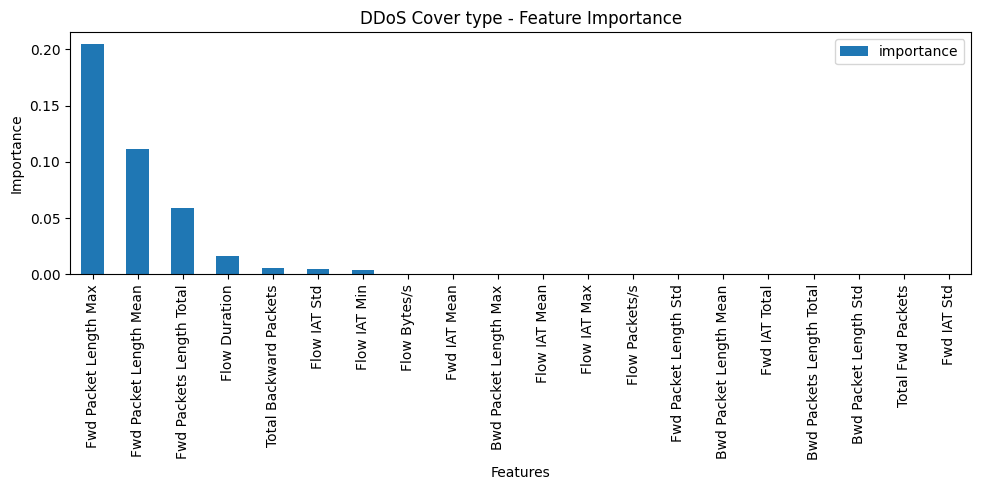

-----------------------------------------------------------------------------------------------




feature_importances {'Portscan': ['Flow IAT Min', 'Fwd IAT Std', 'Bwd Packet Length Std', 'Bwd Packet Length Mean', 'Total Backward Packets'], 'Botnet': ['Flow Duration', 'Flow IAT Mean', 'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Fwd IAT Std'], 'Bruteforce': ['Bwd Packet Length Max', 'Bwd Packets Length Total', 'Fwd Packets Length Total', 'Fwd Packet Length Mean', 'Total Fwd Packets'], 'Webattack': ['Fwd IAT Std', 'Fwd Packets Length Total', 'Flow Bytes/s', 'Flow IAT Max', 'Fwd Packet Length Max'], 'DoS': ['Bwd Packet Length Std', 'Fwd Packet Length Mean', 'Fwd IAT Total', 'Fwd Packet Length Max', 'Flow IAT Mean'], 'Infiltration': ['Flow IAT Min', 'Flow Bytes/s', 'Flow IAT Max', 'Fwd IAT Total', 'Flow Duration'], 'DDoS': ['Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packets Length Total', 'Flow Duration', 'Total Backward Packets']}
Total operation time: =  57712.64

In [20]:
seconds = time.time()

csv_file = 'DDoS.csv'
print('csv file', csv_file)

def train_individual_model(model, X, y):
    model.fit(X, y)
    return model
    
X_df, y_df, df = get_anomaly_X_y_from_csv(csv_file, main_labels, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER)

#computing the feature importances
forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
forest.fit(X_df, y_df)
importances = forest.feature_importances_
label = csv_file.split(".")[0]
print('importances', importances, label)
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
refclasscol=list(df.columns.values)
impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
impor_bars = impor_bars.sort_values('importance',ascending=False)
important_features = impor_bars['Features'].to_list()[:5]
impor_bars = impor_bars.set_index('Features')
print('important_features', important_features)
feature_importances[label] = important_features

X_scaled_df = X_df.copy()
X_scaled_df[NUMERICAL_COLUMNS] = scaler.transform(X_scaled_df[NUMERICAL_COLUMNS])

svm = SVC()
knn = KNeighborsClassifier(n_neighbors=5)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
logistic_regression = LogisticRegression(max_iter=1000)
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

X_train_class = df.iloc[:, df.columns.get_indexer(important_features)]
X_train_class_scaled = X_scaled_df.iloc[:, df.columns.get_indexer(important_features)]
# print('X_train_class', X_train_class)
y_train_class = y_df
# print('y_train_class', y_train_class)
if len(y_train_class) > 0:  # Ensure there are samples for this class
    scaled_models = [svm, knn, logistic_regression]
    non_scaled_models = [decision_tree, random_forest, gradient_boosting]
    
    # Train scaled models
    scaled_models = Parallel(n_jobs=-1)(
        delayed(train_individual_model)(model, X_train_class_scaled, y_train_class)
        for model in scaled_models
    )
    
    # Train non-scaled models
    non_scaled_models = Parallel(n_jobs=-1)(
        delayed(train_individual_model)(model, X_train_class, y_train_class)
        for model in non_scaled_models
    )
    
    # Combine trained models
    svm, knn, logistic_regression = scaled_models
    decision_tree, random_forest, gradient_boosting = non_scaled_models
else:
    print(f'no data for {label}')
    
SVMs[label] = svm

# Create an ensemble from the classifiers using VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('svm', svm),
    ('knn', knn),
    ('dt', decision_tree),
    ('rf', random_forest),
    ('lr', logistic_regression),
    ('gb', gradient_boosting)
], voting='hard')  # Use 'soft' for probability-based voting
voting_clf.fit(X_train_class_scaled, y_train_class)
ensemble_models[label] = voting_clf

plt.rcParams['figure.figsize'] = (10, 5)
impor_bars.plot.bar();
# #printing the feature importances  
count=0
fea_ture=label+"=["
for i in impor_bars.index:
    fea_ture=fea_ture+"\""+str(i)+"\","
    count+=1
    if count==5:
        fea_ture=fea_ture[0:-1]+"]"
        break     
print(label,"importance list:")
print(label,"\n",impor_bars.head(20),"\n\n\n")
print(fea_ture)
plt.title(label+" Cover type - Feature Importance")
plt.ylabel('Importance')
plt.savefig(os.path.join(FEATURE_FOLDER, label+".pdf"),bbox_inches='tight', format = 'pdf')
# ths.write((  fea_ture ) )
plt.tight_layout()
plt.show()
print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances', feature_importances)
print("Total operation time: = ", time.time() - seconds, "seconds")
ths.close()

In [22]:
print(feature_importances)

{'Portscan': ['Flow IAT Min', 'Fwd IAT Std', 'Bwd Packet Length Std', 'Bwd Packet Length Mean', 'Total Backward Packets'], 'Botnet': ['Flow Duration', 'Flow IAT Mean', 'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Fwd IAT Std'], 'Bruteforce': ['Bwd Packet Length Max', 'Bwd Packets Length Total', 'Fwd Packets Length Total', 'Fwd Packet Length Mean', 'Total Fwd Packets'], 'Webattack': ['Fwd IAT Std', 'Fwd Packets Length Total', 'Flow Bytes/s', 'Flow IAT Max', 'Fwd Packet Length Max'], 'DoS': ['Bwd Packet Length Std', 'Fwd Packet Length Mean', 'Fwd IAT Total', 'Fwd Packet Length Max', 'Flow IAT Mean'], 'Infiltration': ['Flow IAT Min', 'Flow Bytes/s', 'Flow IAT Max', 'Fwd IAT Total', 'Flow Duration'], 'DDoS': ['Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packets Length Total', 'Flow Duration', 'Total Backward Packets']}


In [23]:
# Initialize variables to track the best model and best performance
best_k = None
best_score = -1
best_model = None

seconds = time.time()

for k in range(3, 21, 2):
    wandb.init(project="pipeline-knn-cicids-dataset", name=str(k)+" neighbours")
    print("k: ", k)
    
    # Step 1: Train KNN to classify
    # knn = KNeighborsClassifier(n_neighbors=k)
    # knn.fit(X_train_scaled_df, y_train_df)
    # knn.fit(X_train_df, y_train_df)
    
    # Step 2: Predict classes for the test set
    # X_test_df = X_test_df[:TEST_COUNT]
    # X_test_scaled_df = X_test_scaled_df[:TEST_COUNT]
    # y_test_df = y_test_df[:TEST_COUNT]

    # Step 1: Initialize KNN classifier with current k
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Step 2: Perform 5-fold cross-validation on the training set
    cv_scores = cross_val_score(knn, X_train_df, y_train_df, cv=5, scoring='accuracy')
    avg_cv_score = cv_scores.mean()  # Get the average cross-validation score
    print(f"Cross-validation score for k={k}: {avg_cv_score}")
    
    # knn_predictions = knn.predict(X_test_scaled)
    # predictions = knn.predict(X_test_df)
    # print('knn_predictions', predictions)
    
    op_time = time.time() - seconds
    print("Total operation time: = ", op_time, "seconds")
    
    # conf_matrix, class_report, acc_score = evaluate(y_test_df, predictions, heading='-----KNN Evaluation-----')
    # wandb_log(conf_matrix, class_report, acc_score)
    
    wandb.log({
        "Cross-validation Score": avg_cv_score,
        "Total operation time": op_time
    })

     # Step 3: Track the best `k` based on the highest cross-validation score
    if avg_cv_score > best_score:
        best_score = avg_cv_score
        best_k = k
        best_model = knn  # Save the KNN model with the best `k`

    wandb.finish()

# After the loop: Train the best KNN model on the entire training set
print(f"The best k is {best_k} with a cross-validation score of {best_score}")
best_model.fit(X_train_df, y_train_df)

# Step 4: Evaluate the best model on the test set
X_test_df = X_test_df[:TEST_COUNT]
y_test_df = y_test_df[:TEST_COUNT]

# Make predictions on the test set
knn_predictions = best_model.predict(X_test_df)
print("Final predictions using the best model:", knn_predictions)

# Evaluate the performance on the test set
conf_matrix, class_report, acc_score = evaluate(y_test_df, knn_predictions, heading="Best KNN Model Evaluation")
print(f"Accuracy on test set with best k={best_k}: {acc_score}")

# Log the final test results to W&B
wandb.init(project="pipeline-knn-cicids-dataset", name="best_model_evaluation")
wandb_log(conf_matrix, class_report, acc_score)
wandb.finish()

k:  3


KeyboardInterrupt: 

In [24]:
wandb.finish()

In [25]:
seconds = time.time()

# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_scaled_df, y_train_df)
knn.fit(X_train_df, y_train_df)

# Step 2: Predict classes for the test set
X_test_df = X_test_df[:TEST_COUNT]
X_test_scaled_df = X_test_scaled_df[:TEST_COUNT]
y_test_df = y_test_df[:TEST_COUNT]

# knn_predictions = knn.predict(X_test_scaled)
knn_predictions = knn.predict(X_test_df)
print('knn_predictions', knn_predictions)

print("Total operation time: = ",time.time()- seconds ,"seconds")

knn_predictions [0 4 0 3 0 0 0 0 0 0 0 0 3 0 0 0 0 1 3 2 0 3 0 0 0 0 0 0 3 0 0 0 0 0 0 4 0
 0 0 0 2 0 4 0 3 0 0 0 4 1 0 0 4 0 0 0 0 0 4 3 0 0 0 0 0 0 0 0 0 4 0 0 3 0
 4 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 1 0 0 0 3 0 2 0 0 0 0 0 0 3 0 0 0 0 3
 0 0 3 0 4 0 4 0 0 0 3 4 0 3 0 4 0 0 0 0 0 0 0 0 2 0 4 1 0 0 0 0 3 0 0 0 0
 0 1 0 0 0 0 0 0 4 0 1 0 0 0 0 0 0 3 1 0 0 0 0 3 0 0 0 3 0 3 3 3 0 0 0 0 0
 0 0 3 0 3 0 0 0 3 0 0 0 0 4 4 0 4 0 4 0 0 0 0 0 0 0 0 0 0 3 1 3 0 0 0 0 0
 3 0 0 0 3 0 0 0 0 3 3 0 0 0 0 0 1 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4
 3 0 0 0 0 0 0 0 3 0 3 0 0 0 4 0 0 0 0 0 0 3 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3 0 0 0 0 3 0 0 0 0 0 3
 3 3 0 0 0 0 0 0 0 4 3 0 0 0 0 0 0 0 0 0 3 0 0 3 0 0 0 3 3 3 0 0 3 0 0 0 0
 0 0 0 0 0 0 4 4 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 4 3 0 0 0 3 0 0 0
 0 3 0 0 0 0 0 0 4 0 0 0 0 0 0 0 1 0 0 3 2 3 0 0 0 0 0 3 0 0 1 0 3 0 0 0 0
 0 0 0 3 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 4 0 0 0 0 0 0
 0 0 0 3 

In [26]:
print(len(X_test_scaled_df))

500


In [27]:
print(SVMs)

{'Portscan': SVC(), 'Botnet': SVC(), 'Bruteforce': SVC(), 'Webattack': SVC(), 'DoS': SVC(), 'Infiltration': SVC(), 'DDoS': SVC()}


In [28]:
svm_predictions = []
seconds = time.time()

X_test_df = X_test_df[:TEST_COUNT]
X_test_scaled_df = X_test_scaled_df[:TEST_COUNT]
y_test_df = y_test_df[:TEST_COUNT]

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    if knn_predictions[i] == NORMAL_TARGET:
        svm_predictions.append((0, NORMAL_TARGET, y_test_df.iloc[i]))
        continue
    predicted_label = TARGET_DICT[knn_predictions[i]]
    print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    # Select features for the SVM
    test_instance_selected_df = test_instance_df[selected_features]
    svm_prediction = svm_model.predict(test_instance_selected_df)
    print('svm prediction: ', svm_prediction, 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test_df.iloc[i])
    svm_predictions.append((svm_prediction, INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print("Total operation time: = ", time.time() - seconds, "seconds")

predicted_label DoS
svm prediction:  [0] knn prediction:  4 actual value:  4
predicted_label DDoS
svm prediction:  [0] knn prediction:  3 actual value:  3
predicted_label DDoS
svm prediction:  [0] knn prediction:  3 actual value:  3
predicted_label Botnet
svm prediction:  [1] knn prediction:  1 actual value:  1
predicted_label DDoS
svm prediction:  [0] knn prediction:  3 actual value:  3
predicted_label Bruteforce
svm prediction:  [0] knn prediction:  2 actual value:  2
predicted_label DDoS
svm prediction:  [0] knn prediction:  3 actual value:  3
predicted_label DDoS
svm prediction:  [1] knn prediction:  3 actual value:  3
predicted_label DoS
svm prediction:  [0] knn prediction:  4 actual value:  4
predicted_label Bruteforce
svm prediction:  [0] knn prediction:  2 actual value:  2
predicted_label DoS
svm prediction:  [0] knn prediction:  4 actual value:  4
predicted_label DDoS
svm prediction:  [0] knn prediction:  3 actual value:  3
predicted_label DoS
svm prediction:  [0] knn predicti

In [31]:
!pip install seaborn
import seaborn as sns

anomaly_mask 500
[0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 3, 2, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 4, 0, 3, 0, 0, 0, 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 4, 0, 4, 0, 0, 0, 3, 4, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 4, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0

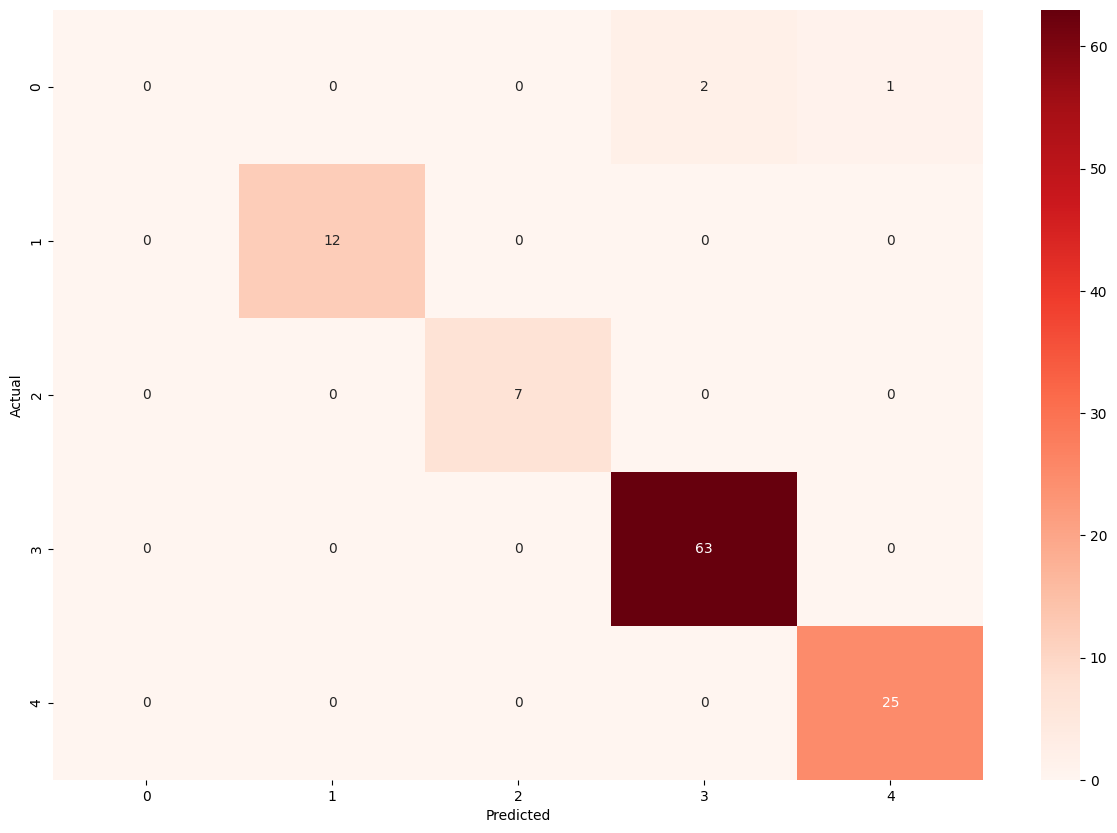


Classification Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7.0}, '3': {'precision': 0.9692307692307692, 'recall': 1.0, 'f1-score': 0.9843749999999999, 'support': 63.0}, '4': {'precision': 0.9615384615384616, 'recall': 1.0, 'f1-score': 0.9803921568627451, 'support': 25.0}, 'accuracy': 0.9727272727272728, 'macro avg': {'precision': 0.7861538461538462, 'recall': 0.8, 'f1-score': 0.792953431372549, 'support': 110.0}, 'weighted avg': {'precision': 0.9463636363636363, 'recall': 0.9727272727272728, 'f1-score': 0.9593220811051693, 'support': 110.0}}
Accuracy: 0.9727272727272728


/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.97273
f1-score_avg,0.95932
precision_avg,0.94636
recall_avg,0.97273


SVM Evaluation (for all)
Confusion Matrix:
[[383   0   0   2   1   0]
 [  0  12   0   0   0   0]
 [  0   0   7   0   0   0]
 [  0   0   0  63   0   0]
 [  0   0   0   0  25   0]
 [  7   0   0   0   0   0]]


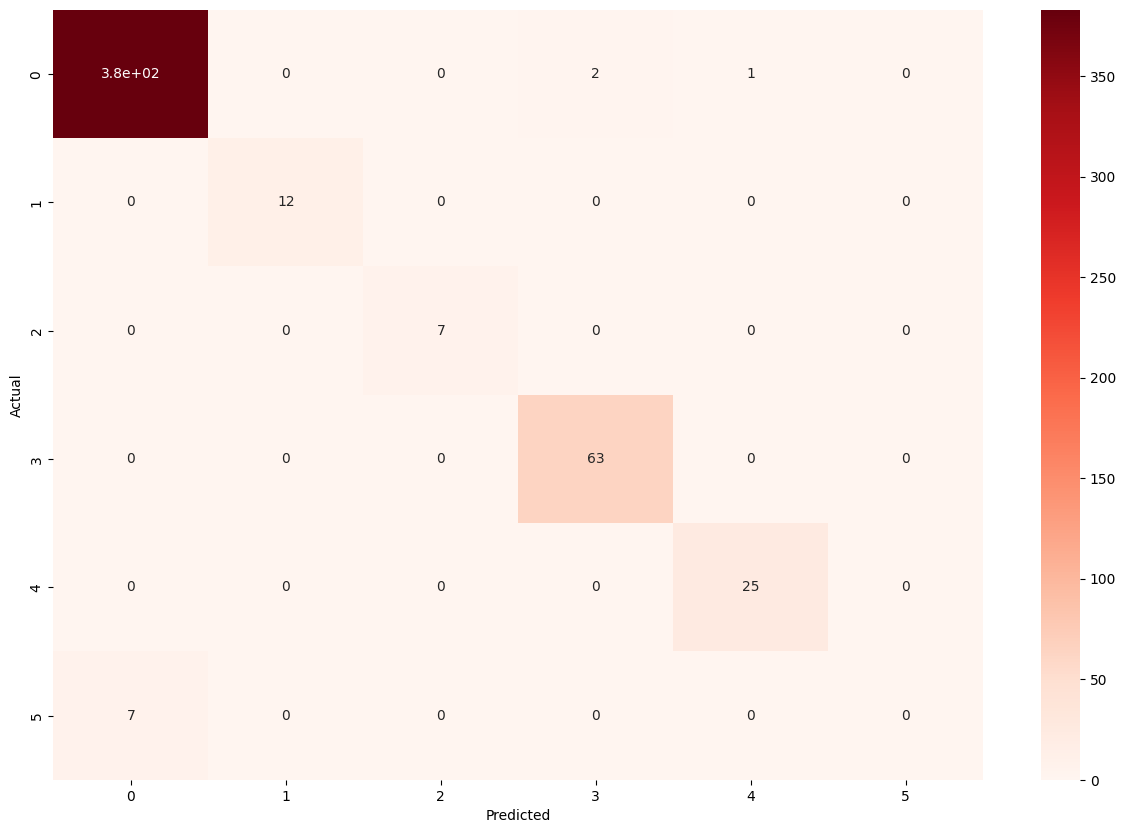

/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
{'0': {'precision': 0.982051282051282, 'recall': 0.9922279792746114, 'f1-score': 0.9871134020618556, 'support': 386.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7.0}, '3': {'precision': 0.9692307692307692, 'recall': 1.0, 'f1-score': 0.9843749999999999, 'support': 63.0}, '4': {'precision': 0.9615384615384616, 'recall': 1.0, 'f1-score': 0.9803921568627451, 'support': 25.0}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}, 'accuracy': 0.98, 'macro avg': {'precision': 0.8188034188034189, 'recall': 0.8320379965457686, 'f1-score': 0.8253134264874334, 'support': 500.0}, 'weighted avg': {'precision': 0.9663435897435897, 'recall': 0.98, 'f1-score': 0.9731024042348897, 'support': 500.0}}
Accuracy: 0.98


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.98
f1-score_avg,0.9731
precision_avg,0.96634
recall_avg,0.98


In [32]:
wandb.init(project="pipeline-cicids-dataset", name="anomalies-svm-only")

# Now evaluate SVM predictions only for the anomalies detected by KNN
# Create a mask for test instances that KNN classified as anomalies
anomaly_mask = knn_predictions != NORMAL_TARGET  # Assuming normal_target is your normal class
print('anomaly_mask', len(anomaly_mask))

# Get true labels and predictions for anomalies
svm_predictions_actual = [t[1] for t in svm_predictions]
print(svm_predictions_actual)
# svm_predictions_actual = np.array(svm_predictions_actual)
svm_predictions_actual_df = pd.DataFrame(svm_predictions_actual, columns=[TARGET_COLUMN])
y_test_anomalies_df = y_test_df[anomaly_mask]
svm_predictions_anomalies_df = svm_predictions_actual_df[anomaly_mask]
print('Lengths: ', len(y_test_anomalies_df), len(svm_predictions_anomalies_df))

# Evaluate SVM only on the anomalies
conf_matrix, class_report, acc_score = evaluate(y_test_anomalies_df, svm_predictions_anomalies_df, heading='SVM Evaluation (for anomalies)')
wandb_log(conf_matrix, class_report, acc_score)
wandb.finish()

# Evaluate SVM on all test data
wandb.init(project="pipeline-cicids-dataset", name="overall-svm-only")
conf_matrix, class_report, acc_score = evaluate(y_test_df, svm_predictions_actual_df, heading='SVM Evaluation (for all)')
wandb_log(conf_matrix, class_report, acc_score)
wandb.finish()

In [33]:
ensemble_predictions = []
seconds = time.time()

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    if knn_predictions[i] == NORMAL_TARGET:
        ensemble_predictions.append((0, NORMAL_TARGET, y_test_df.iloc[i]))
        continue
    predicted_label = TARGET_DICT[knn_predictions[i]]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    model = ensemble_models[predicted_label]
    
    # Select features for the ensemble
    test_instance_selected_df = test_instance_df[selected_features]
    ensemble_prediction = model.predict(test_instance_selected_df)
    print('ensemble prediction: ', ensemble_prediction, 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test_df.iloc[i])
    ensemble_predictions.append((ensemble_prediction, INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print("Total operation time: = ", time.time() - seconds, "seconds")

ensemble prediction:  [0] knn prediction:  4 actual value:  4
ensemble prediction:  [0] knn prediction:  3 actual value:  3
ensemble prediction:  [0] knn prediction:  3 actual value:  3
ensemble prediction:  [0] knn prediction:  1 actual value:  1
ensemble prediction:  [0] knn prediction:  3 actual value:  3
ensemble prediction:  [0] knn prediction:  2 actual value:  2
ensemble prediction:  [0] knn prediction:  3 actual value:  3
ensemble prediction:  [0] knn prediction:  3 actual value:  3
ensemble prediction:  [0] knn prediction:  4 actual value:  4
ensemble prediction:  [0] knn prediction:  2 actual value:  2
ensemble prediction:  [0] knn prediction:  4 actual value:  4
ensemble prediction:  [0] knn prediction:  3 actual value:  3
ensemble prediction:  [0] knn prediction:  4 actual value:  4
ensemble prediction:  [0] knn prediction:  1 actual value:  1
ensemble prediction:  [0] knn prediction:  4 actual value:  4
ensemble prediction:  [0] knn prediction:  4 actual value:  4
ensemble

anomaly_mask 500
[0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 3, 2, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 4, 0, 3, 0, 0, 0, 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 4, 0, 4, 0, 0, 0, 3, 4, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 4, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0

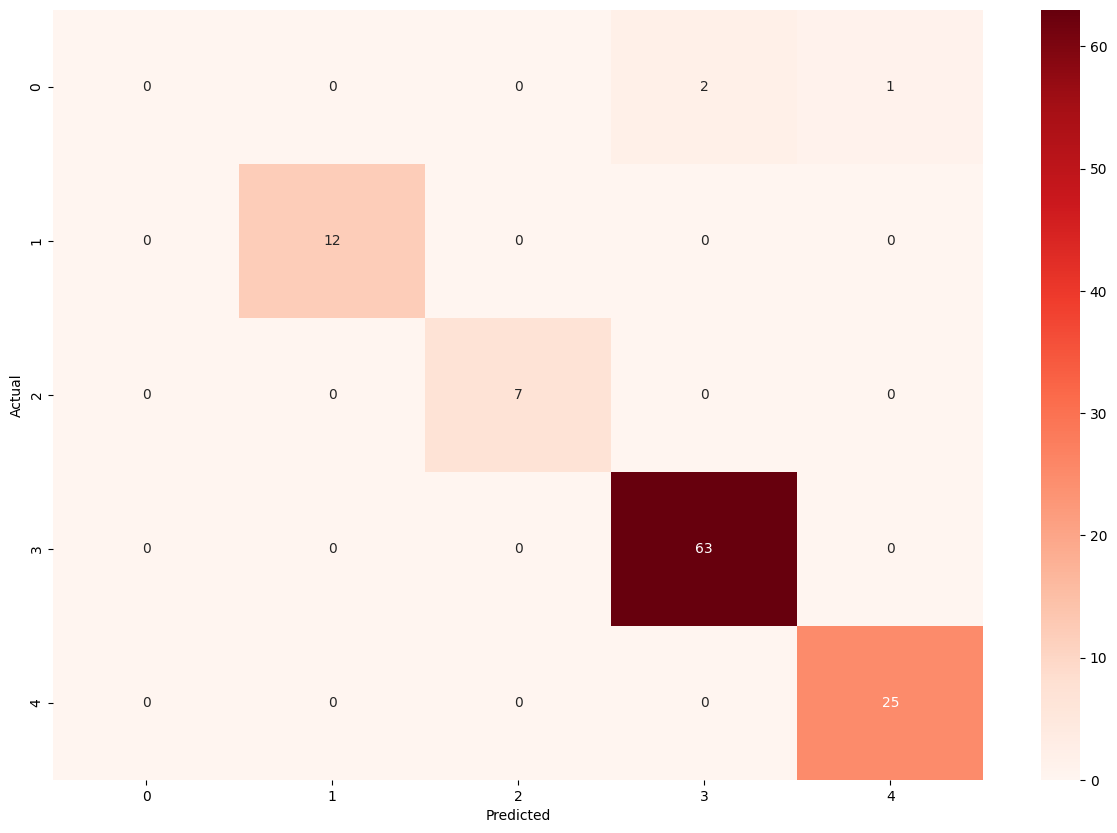


Classification Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7.0}, '3': {'precision': 0.9692307692307692, 'recall': 1.0, 'f1-score': 0.9843749999999999, 'support': 63.0}, '4': {'precision': 0.9615384615384616, 'recall': 1.0, 'f1-score': 0.9803921568627451, 'support': 25.0}, 'accuracy': 0.9727272727272728, 'macro avg': {'precision': 0.7861538461538462, 'recall': 0.8, 'f1-score': 0.792953431372549, 'support': 110.0}, 'weighted avg': {'precision': 0.9463636363636363, 'recall': 0.9727272727272728, 'f1-score': 0.9593220811051693, 'support': 110.0}}
Accuracy: 0.9727272727272728


/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.97273
f1-score_avg,0.95932
precision_avg,0.94636
recall_avg,0.97273


Ensemble Evaluation (for all)
Confusion Matrix:
[[383   0   0   2   1   0]
 [  0  12   0   0   0   0]
 [  0   0   7   0   0   0]
 [  0   0   0  63   0   0]
 [  0   0   0   0  25   0]
 [  7   0   0   0   0   0]]


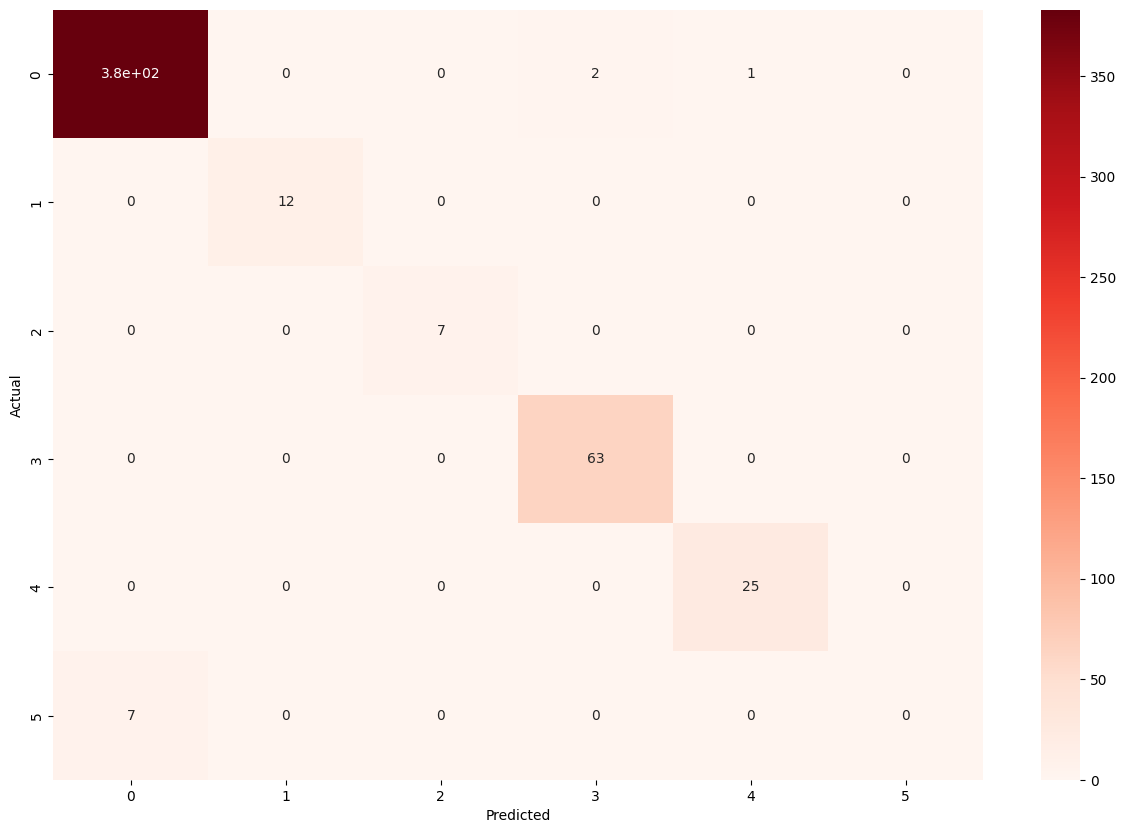


Classification Report:
{'0': {'precision': 0.982051282051282, 'recall': 0.9922279792746114, 'f1-score': 0.9871134020618556, 'support': 386.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7.0}, '3': {'precision': 0.9692307692307692, 'recall': 1.0, 'f1-score': 0.9843749999999999, 'support': 63.0}, '4': {'precision': 0.9615384615384616, 'recall': 1.0, 'f1-score': 0.9803921568627451, 'support': 25.0}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}, 'accuracy': 0.98, 'macro avg': {'precision': 0.8188034188034189, 'recall': 0.8320379965457686, 'f1-score': 0.8253134264874334, 'support': 500.0}, 'weighted avg': {'precision': 0.9663435897435897, 'recall': 0.98, 'f1-score': 0.9731024042348897, 'support': 500.0}}
Accuracy: 0.98


/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.98
f1-score_avg,0.9731
precision_avg,0.96634
recall_avg,0.98


In [34]:
wandb.init(project="pipeline-cicids-dataset", name="anomalies-ensemble")

# Now evaluate ensemble predictions only for the anomalies detected by KNN
# Create a mask for test instances that KNN classified as anomalies
anomaly_mask = knn_predictions != NORMAL_TARGET  # Assuming normal_target is your normal class
print('anomaly_mask', len(anomaly_mask))

# Get true labels and predictions for anomalies
ensemble_predictions_actual = [t[1] for t in ensemble_predictions]
print(ensemble_predictions_actual)
ensemble_predictions_actual_df = pd.DataFrame(ensemble_predictions_actual, columns=[TARGET_COLUMN])
y_test_anomalies_df = y_test_df[anomaly_mask]
ensemble_predictions_anomalies_df = ensemble_predictions_actual_df[anomaly_mask]
print('Lengths: ', len(y_test_anomalies_df), len(ensemble_predictions_anomalies_df))

# Evaluate ensemble only on the anomalies
conf_matrix, class_report, acc_score = evaluate(y_test_anomalies_df, ensemble_predictions_anomalies_df, heading='Ensemble Evaluation (for anomalies)')
wandb_log(conf_matrix, class_report, acc_score)
wandb.finish()

# Evaluate ensemble on all test data
wandb.init(project="pipeline-cicids-dataset", name="overall-ensemble")
conf_matrix, class_report, acc_score = evaluate(y_test_df, ensemble_predictions_actual_df, heading='Ensemble Evaluation (for all)')
wandb_log(conf_matrix, class_report, acc_score)
wandb.finish()